The first thing was to import the data and sort the values to better manage of the data

In [3]:
import pandas as pd
df=pd.read_csv(r'/content/deaths08.csv')
dfn=df[['hod','cod']].sort_values(by=['hod','cod'])
dfn=dfn.reset_index(drop=True)
print(dfn)

        hod  cod
0         0  A02
1         0  A04
2         0  A04
3         0  A04
4         0  A04
...     ...  ...
539525   99  Y57
539526   99  Y57
539527   99  Y57
539528   99  Y86
539529   99  Y86

[539530 rows x 2 columns]


Next it was needed to count the frequency of the values grouped by hour of death and cause of death. It is necessary to drop the null values and to drop duplicate values (if any). Obtaining the count of the number of deaths in each hour for each cause.

In [4]:
hod=df[['hod','cod']].sort_values(by=['hod','cod'])
hodn=hod.groupby(['hod','cod'])['cod'].count()
hod=hod.dropna()
hod=hod.drop_duplicates()
hod.rename(columns={'cod': 'code'}, inplace=True)
hod=hod.reset_index(drop=True)
hodn=hodn.reset_index(drop=True)
hod['freq']=hodn

We import the other dataset containing the names of all the cause of death by the "code" variable

In [5]:
codes=pd.read_csv(r'/content/icd-main.csv')

It was needed to merge both datasets obtainined and drop duplicate values (if any) In addition because we add a new data set is better to use new indexes

In [6]:
hod2=hod.merge(codes, on='code', how='left') 
hod2=hod2.drop_duplicates(subset=['hod','code'])
hod2=hod2.reset_index(drop=True)

The cause and hour of death for each one was divided by the sum of the cause of death in that hour specifically

In [7]:
hodnw=hod.merge(hod2.groupby('code')['freq'].sum(), on='code', how='inner')
hodnw=hodnw.sort_values(by=['hod','code'])
hodnw=hodnw.reset_index()
hod2['prop']=hod2['freq']/hodnw['freq_y']

The total cause of deaths frquency for each hour was divided by the total cause of death for any hour. In addition it was obtained the frequency of the overall average death for each hour

In [8]:
hodnf=hod.merge(hod2.groupby('hod')['freq'].sum(), on='hod', how='inner')
hod2['freq_all']=hodnf['freq_y']
hod2['prop_all']=hodnf['freq_y']/hod2['freq'].sum()

To find the deviation betweenthe temporal pattern of each cause of death and the overall temporal pattern is used a mean squared deviation. To ensure that the disease is representative it is used only diseases with more than 50 total deaths.

In [9]:
n=hod2.groupby('code')['freq'].sum()
hod2['diff']=(hod2['prop']-hod2['prop_all'])**2
dist=hod2.groupby('code')['diff'].mean()
data={'dist':dist, 'n':n}
result=pd.DataFrame(data)
result=result[result['n'] > 50]

Linear scale plot of total frequency (n) vs deviation of frequency (dist)

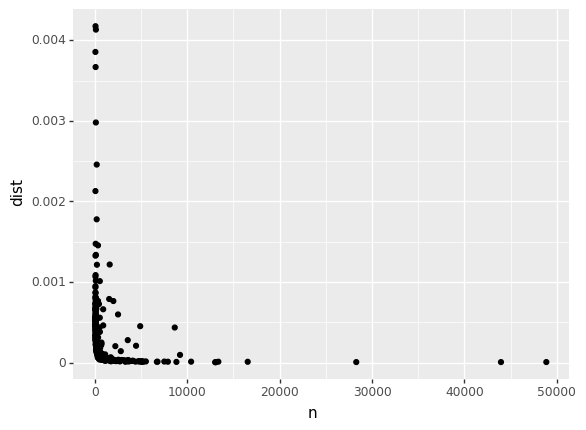

<ggplot: (8768049592308)>

In [10]:
import numpy as np
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
ggplot(result) + aes(x="n", y="dist") + geom_point()

Logarithmic scale plot of total frequency (n) vs deviation of frequency (dist)

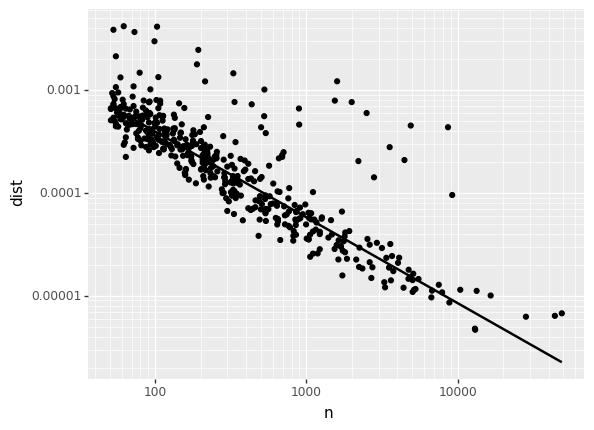

<ggplot: (8768049479147)>

In [11]:
ggplot(result) + aes(x="n", y="dist") + geom_point() + scale_x_log10(breaks = (100, 1000, 10000), labels = (100, 1000, 10000)) + scale_y_log10(breaks = (0.001, 0.0001, 0.00001), labels = ("0.001", "0.0001", "0.00001")) + geom_smooth (method = "rlm", se = False)



Linear regression method of Robust fitting of linear Modes (RLM) obtained by the bibliography. Obtaining values bigger than a threshold (n > 350 and threshold (resid obtained by the linear modes) > 1.5) 

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
result['logn']=np.log(result['n'])
result['logdist']=np.log(result['dist'])
rlm_result=smf.rlm('logdist ~ logn', data=result).fit()
result['resid']=rlm_result.resid
unusual=result[result['resid']>1.5]
hod_unusual=pd.merge(hod2,unusual, on='code')
hod_unusualbig=hod_unusual[hod_unusual['n']>350]
hod_unusualsmall=hod_unusual[hod_unusual['n']<=350]

Residuals from a robust linear model predicting logarithm of the deviation of the frequency in the linear regression (log(dist)) and logarithm of total frequency (log(n))

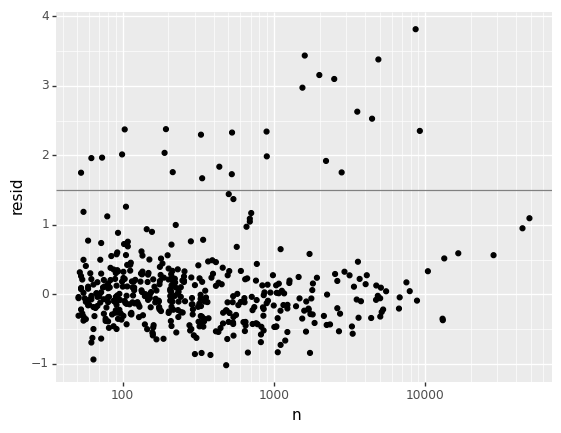

<ggplot: (8768049392749)>

In [13]:
ggplot(result, aes(x='n', y='resid')) + geom_hline(yintercept = 1.5, colour = "grey") + geom_point() + scale_x_log10(breaks = (100, 1000, 10000), labels = (100, 1000, 10000))

Causes of death with unusual temporal couse for each unusual cause (threshold>1.5) and the frequency is smaller than n<350

/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


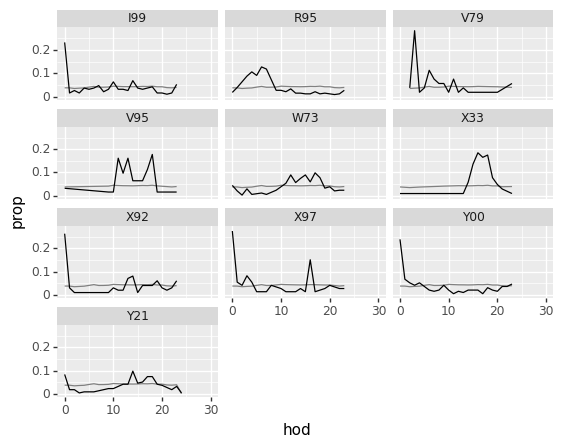

<ggplot: (8768049390117)>

In [14]:
ggplot(hod_unusualsmall, aes(x="hod", y="prop")) + geom_line(aes(y='prop_all'), color="grey")+ geom_line()+facet_wrap('code',ncol=3) + xlim(0,30)

Causes of death with unusual temporal couse for each unusual cause (threshold>1.5) and the frequency is bigger than n>350

/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


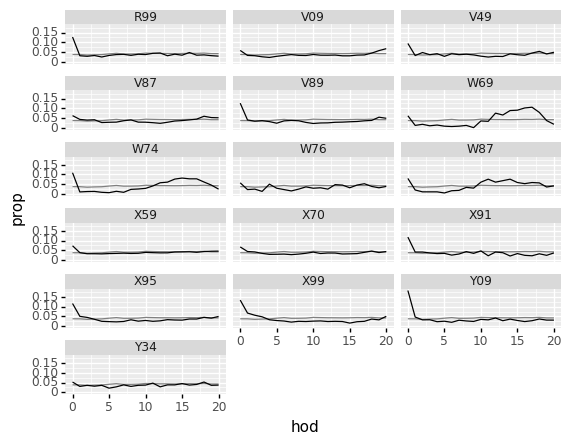

<ggplot: (8774144785996)>

In [33]:
ggplot(hod_unusualbig, aes(x="hod", y="prop")) + geom_line(aes(y='prop_all'), color="grey")+ geom_line()+facet_wrap('code',ncol=3) + xlim(0,20)

We will fit a linear regression model, it is imported the needed libraries and we obtain the value of SRME to see the correlation

[-1.83609922]
[[-0.77339295]]
RMSE:  0.29629558516116894


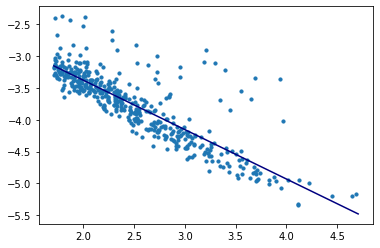

In [20]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
result['nlog']=np.log10(result['n'])
result['distlog']=np.log10(result['dist'])
lr = linear_model.LinearRegression()
x=result['nlog'].values.reshape(-1,1)
y=result['distlog'].values.reshape(-1,1)
lr.fit(x, y)
y_pred = lr.predict(x)
interr=lr.intercept_
coeff=lr.coef_
rmse = np.sqrt(mean_squared_error(y,y_pred))
print("RMSE: ",rmse)
print('y=',coeff,'x+',interr)
line_X = np.arange(x.min(), 5)[:, np.newaxis]
line_y = lr.predict(line_X)
line_Xls=line_X 
line_yls=line_y

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(x, y, s=6, c='cornflowerblue',alpha=0.8)
plt.plot(line_X, line_y, color='green',alpha=1, label='Least squares regression', linewidth=2.5)

plt.xlabel("Nlog", fontsize=14)
plt.ylabel("Distlog", fontsize=14)
plt.legend(loc='lower left')
plt.show()

We will fit a linear Lasso model, it is imported the 
needed libraries and we obtain the value of SRME to see the correlation

[-1.90617952]
[-0.74553294]
RMSE:  0.29676535157405365


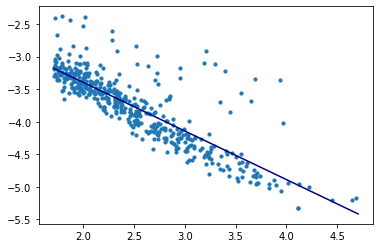

In [21]:

lr = linear_model.Lasso(alpha=0.01)
x=result['nlog'].values.reshape(-1,1)
y=result['distlog'].values.reshape(-1,1)
lr.fit(x, y)
y_pred = lr.predict(x)
print(lr.intercept_)
print(lr.coef_)
rmse = np.sqrt(mean_squared_error(y,y_pred))
print("RMSE: ",rmse)


line_X = np.arange(x.min(), 5)[:, np.newaxis]
line_y = lr.predict(line_X)
line_Xlas=line_X 
line_ylas=line_y

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(x, y, s=6, c='cornflowerblue',alpha=0.8)
plt.plot(line_X, line_y, color='black',alpha=0.8, label='Lasso regression', linewidth=2.5)

plt.xlabel("Nlog", fontsize=14)
plt.ylabel("Distlog", fontsize=14)
plt.legend(loc='lower left')
plt.show()

We will fit a linear Ridge model, it is imported the 
needed libraries and we obtain the value of SRME to see the correlation

[-1.84206318]
[[-0.77102201]]
RMSE:  0.2962989900330082


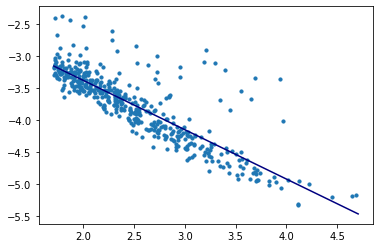

In [22]:
lr = linear_model.Ridge(alpha=0.5)
x=result['nlog'].values.reshape(-1,1)
y=result['distlog'].values.reshape(-1,1)
lr.fit(x, y)
y_pred = lr.predict(x)
print(lr.intercept_)
print(lr.coef_)
rmse = np.sqrt(mean_squared_error(y,y_pred))
print("RMSE: ",rmse)

line_X = np.arange(x.min(), 5)[:, np.newaxis]
line_y = lr.predict(line_X)
line_Xrid=line_X 
line_yrid=line_y

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(x, y, s=6, c='cornflowerblue',alpha=0.8)
plt.plot(line_X, line_y, color='r',alpha=0.8, label='Ridge regression', linewidth=2.5)

plt.xlabel("Nlog", fontsize=14)
plt.ylabel("Distlog", fontsize=14)
plt.legend(loc='lower left')
plt.show()

We will put together

In [ ]:
xa = np.linspace(x.min(),4.7,10)
ya = -0.8*xa-2
ya_pred = -0.8*x-2

rmse = np.sqrt(mean_squared_error(y,ya_pred))
print("RMSE: ",rmse)

fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(x, y, s=6, c='cornflowerblue',alpha=0.8)

plt.plot(xa, ya,'-y',alpha=1, label='Random values', linewidth=2.5)
plt.plot(line_Xls, line_yls, color='green',alpha=1, label='Least squares regression', linewidth=2.5)
plt.plot(line_Xlas, line_ylas, color='black',alpha=0.8, label='Lasso regression', linewidth=2.5)
plt.plot(line_Xrid, line_yrid, color='r',alpha=0.8, label='Ridge regression', linewidth=2.5)

plt.xlabel("Nlog", fontsize=14)
plt.ylabel("Distlog", fontsize=14)
plt.legend(loc='lower left')
plt.show()